In [1]:
%load_ext autoreload
%autoreload 2

import gsum as gm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from stats_utils import *
from matter import *
import seaborn as sns
import time
from itertools import product

%matplotlib inline

In [2]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'serif'
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, format='pdf')

In [3]:
df = pd.read_csv('../data/all_matter_data.csv')
# Convert differences to total prediction at each MBPT order
mbpt_orders = ['Kin', 'MBPT_HF', 'MBPT_2', 'MBPT_3', 'MBPT_4']
df[mbpt_orders] = df[mbpt_orders].apply(np.cumsum, axis=1)
# 'total' is now unnecessary. Remove it.
df.pop('total');

In [4]:
orders = np.array([0, 2, 3, 4])
# body = 'NN-only'
# body = 'NN+3N'
# Lambda = 450
fits = {450: [1, 7], 500: [4, 10]}
train = slice(None, None, 5)
valid = slice(2, None, 5)

savefigs = False

Lb = 600

breakdown_min = 300
breakdown_max = 1000
breakdown_num = 100
Lb_vals = np.linspace(breakdown_min, breakdown_max, breakdown_num)
Lb_logprior_vals = Lb_logprior(Lb_vals)

ls_min = 0.1
ls_max = 1.5
ls_num = 50
ls_vals = np.linspace(ls_min, ls_max, ls_num)
# ls_min = ls_max = ls_num = ls_vals = None

nugget = 1e-4

kernel = RBF(length_scale=1, length_scale_bounds=(5e-2, 4)) + \
    WhiteKernel(noise_level=nugget, noise_level_bounds='fixed')
kernel_theta = kernel.theta
ref = 16

hyperparams = dict(
    center=0,
    disp=0,
    df=1,
    scale=1
)

analyses = []

for body, Lambda in product(['NN+3N'], [450, 500]):
    [fit_n2lo, fit_n3lo] = fits[Lambda]
    mask_fit = np.isin(df['fit'], fits[Lambda]) | np.isnan(df['fit'])
    mask = \
        (df['Body'] == body) & \
        mask_fit & \
        (df['Lambda'] == Lambda)


    df_s = df[mask & (df['x'] == 0.5)]

    kf_s = df_s[df_s['OrderEFT'] == 'LO']['kf'].values
    density = df_s[df_s['OrderEFT'] == 'LO']['n'].values

    Kf_s = kf_s[:, None]
    y_s = np.array([df_s[df_s['OrderEFT'] == order]['MBPT_4'].values for order in df_s['OrderEFT'].unique()]).T
    
    analysis_s = MatterConvergenceAnalysis(
        X=Kf_s, y=y_s, orders=orders, train=train, valid=valid, ref=ref, ratio='kf', density=density,
        kernel=kernel, system='symmetric', fit_n2lo=fit_n2lo, fit_n3lo=fit_n3lo, Lambda=Lambda,
        body=body, savefigs=savefigs, **hyperparams
    )
    analysis_s.setup_posteriors(
        breakdown_min=breakdown_min, breakdown_max=breakdown_max, breakdown_num=breakdown_num,
        ls_min=ls_min, ls_max=ls_max, ls_num=ls_num,
        max_idx=[2, 3], logprior=None
    )
    analyses.append(analysis_s)

Using breakdown = 328.2828282828283 MeV
Using breakdown = 328.2828282828283 MeV
Using breakdown = 321.2121212121212 MeV
Using breakdown = 321.2121212121212 MeV
[1.25 1.3  1.35 1.4  1.45]
[1.25 1.3  1.35 1.4  1.45]


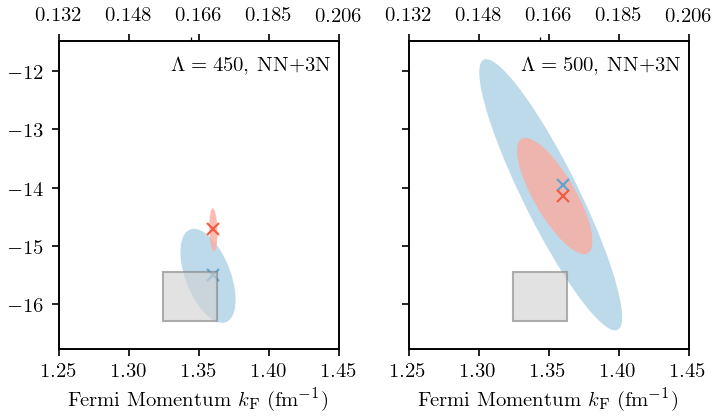

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharex=True, sharey=True)
for i, analysis in enumerate(analyses):
    ax = axes.ravel()[i]
    analysis.plot_saturation(breakdown=None, order=3, nugget=1e-6, ax=ax, alpha=0.8)
    analysis.plot_saturation(breakdown=None, order=4, nugget=1e-6, ax=ax, alpha=0.8)
    ax.text(0.4, 0.9, s=rf'$\Lambda={analysis.Lambda}$, {analysis.body}', transform=ax.transAxes)

fig.tight_layout()

for ax, analysis in zip(axes, analyses):
    kf_ticks = ax.get_xticks()
    print(kf_ticks)
    ax.set_xticks(kf_ticks)
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    d_ticks = analysis.compute_density(kf_ticks)
    ax2.set_xticks(kf_ticks)
    ax2.set_xticklabels([f'{dd:0.3}' for dd in d_ticks])
    ax2.set_xticks([analysis.compute_momentum(0.164)], minor=True)
fig.tight_layout()

fig.savefig('new_figures/coester_ellipses')

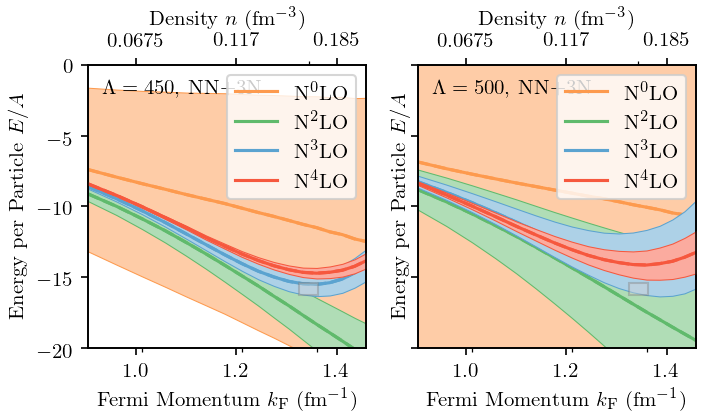

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(5, 3), sharex=False, sharey=True)
for i, analysis in enumerate(analyses):
    ax = axes.ravel()[i]
    analysis.plot_observables(breakdown=None, show_process=True, ax=ax)
    ax.text(0.05, 0.9, s=rf'$\Lambda={analysis.Lambda}$, {analysis.body}', transform=ax.transAxes)
    ax.set_ylim(-20, 0)
fig.tight_layout()
fig.savefig('new_figures/sym-obs-3N-with-empirical')